In [4]:
"""
Notebook : Extraction et Analyse des Tokens WavTokenizer
Objectif : mesurer l'entropie, histogrammes et token dominant
afin de représenter le paysage sonore et coupler
avec les données météo (affichage mensuel et annuel).
"""
# 1. Imports et configuration
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import entropy
from datetime import timedelta
from datetime import datetime
from collections import defaultdict
import seaborn as sns
import re # Importation de re pour les expressions régulières
import tqdm # Importation de tqdm pour la barre de progression
from scipy.optimize import curve_fit # Import curve_fit
from scipy.stats import skew, kurtosis

# Montage de Google Drive
#drive.mount('/content/drive')
#!unzip -q "/content/drive/MyDrive/Exctraction+token/test/result_tokens.zip" -d "/content/drive/MyDrive/Exctraction+token/test/"

In [5]:
# Répertoires et extensions
base_path = "/home/m1projetisi"
chemin_txt = os.path.join(base_path, "WavTokenizer/files_list.txt")
token_dir = os.path.join(base_path, "WavTokenizer/result_tokens_v9")
TOKENS_EXT = '.pt'

# Paramètres d'analysis
BIN_COUNT    = 4096      # Utilise 4096 pour le calcul de l'histogramme complet
WINDOW_SIZE  = 1024    # taille fenêtre glissante pour entropie
STEP         = 512     # décalage de la fenêtre

In [7]:
# 2. Fonctions utilitaires
def compute_entropy(tokens, window=WINDOW_SIZE, step=STEP):
    tokens = np.asarray(tokens)

    if len(tokens) < window:
        return np.array([])

    shape = ((len(tokens) - window) // step + 1, window)
    strides = (tokens.strides[0] * step, tokens.strides[0])
    windows = np.lib.stride_tricks.as_strided(tokens, shape=shape, strides=strides)

    # Preallocate output
    result = np.empty(windows.shape[0], dtype=np.float32)

    for i, w in enumerate(windows):
        counts = np.bincount(w, minlength=4096)
        probs = counts / counts.sum()
        probs = probs[probs > 0]
        result[i] = entropy(probs, base=2)

    return result

def hist_and_dominant(tokens, bins=BIN_COUNT):
    """
    Calcule l'histogramme normalisé et les top_n tokens les plus fréquents (par rang décroissant).
    Retourne :
    - histogramme normalisé (array de 4096 floats)
    - liste des top_n tokens dominants (ex: [138, 412, 58, ...])
    """
    tokens = np.array(tokens)
    
    if tokens.size == 0:
        return np.zeros(bins), []

    hist = np.bincount(tokens, minlength=4096)
    hist_norm = hist / hist.sum() if hist.sum() > 0 else hist

    # Conserve uniquement les tokens dont la fréquence est > 0
    nonzero_indices = np.nonzero(hist)[0]
    top_tokens = nonzero_indices[np.argsort(hist[nonzero_indices])[::-1]]

    return hist_norm, top_tokens

def extract_timestamp_from_filename(filename):
    # Updated regex to match the file name format S4A09154_20190218_163000.flac
    match = re.search(r"_(\d{8})_(\d{6})\.flac", filename)
    if match:
        date_str, time_str = match.groups()
        timestamp_str = f"{date_str}{time_str}"
        return pd.to_datetime(timestamp_str, format="%Y%m%d%H%M%S", errors='coerce')
    return pd.NaT

#  Fonction d'arrondi vers le quart d'heure le plus proche
def arrondir_vers_quart_heure_le_plus_proche(dt):
    minute = (dt.minute // 15) * 15
    dt_bas = dt.replace(minute=minute, second=0, microsecond=0)
    dt_haut = dt_bas + timedelta(minutes=15)
    return dt_bas if abs((dt - dt_bas).total_seconds()) <= abs((dt - dt_haut).total_seconds()) else dt_haut

# Fonction pour traiter les DataFrames météo
def process_meteo_df(df, rename_dict):
    df = df.copy()
    # Check if the first row contains the actual headers
    if 'Date Heure GMT -0300' in df.iloc[0].values:
         df.columns = df.iloc[0].astype(str).str.strip()
         df = df[1:]
    df.columns = df.columns.str.strip()
    df.rename(columns=rename_dict, inplace=True)
    df["datetime"] = pd.to_datetime(df["datetime"], errors='coerce') # Gère les erreurs potentielles dans la conversion de datetime
    df = df.dropna(subset=['datetime']) # Supprime les lignes où la conversion datetime a échoué
    df["rounded_datetime"] = df["datetime"].apply(arrondir_vers_quart_heure_le_plus_proche)
    df = df.drop(columns=["datetime"])
    # Convert relevant columns to numeric, coercing errors to NaN
    for col in rename_dict.values():
        if col != 'datetime':
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df


# 3. Data Processing

# Load and process meteo data
ground_lux_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_ground_lux_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp. °C": "ground_temp",
        "Intensité, lux": "ground_lux"
    }
)

canopy_lux_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_canopy_lux_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp. °C": "canopy_temp",
        "Intensité lux": "canopy_lux"
    }
)

ground_rh_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_ground_rh_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp °C": "ground_temp",
        "HR %": "ground_rh",
        "PtRosée °C": "ground_ptrose"
    }
)

canopy_rh_clean = process_meteo_df(
    pd.read_csv(os.path.join(base_path, "monitor_canopy_rh_2019.csv")),
    rename_dict={
        "Date Heure GMT -0300": "datetime",
        "Temp °C": "canopy_temp",
        "HR %": "canopy_rh",
        "PtRosée °C": "canopy_ptrose"
    }
)

# Combine meteo data into a single dictionary
meteo_par_datetime = defaultdict(dict)

def add_to_meteo_dict(df):
    for _, row in df.iterrows():
        dt = row["rounded_datetime"]
        for col in df.columns:
            if col != "rounded_datetime":
                meteo_par_datetime[dt][col] = row[col]

add_to_meteo_dict(ground_lux_clean)
add_to_meteo_dict(canopy_lux_clean)
add_to_meteo_dict(ground_rh_clean)
add_to_meteo_dict(canopy_rh_clean)


# Process audio data and integrate with meteo data
fichiers_par_date = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

# Read audio files paths from the list
wav_paths = []
if os.path.exists(chemin_txt):
    with open(chemin_txt, "r", encoding="utf-8") as f:
        wav_paths = [line.strip() for line in f if line.strip().lower().endswith(".flac")]
else:
    print(f"Attention : Liste de fichiers non trouvée à {chemin_txt}. Traitement audio ignoré.")


def ensure_flat_numpy(tokens):
    try:
        if isinstance(tokens, torch.Tensor):
            return tokens.numpy().flatten()
        elif isinstance(tokens, np.ndarray):
            return tokens.flatten()
        elif isinstance(tokens, (list, tuple)):
            return np.array(tokens).flatten()
        else:
            return None
    except Exception as e:
        print(f"Erreur lors de la conversion des tokens en numpy aplati : {e}")
        return None

# Process each audio file
for path in tqdm.tqdm(wav_paths, desc="Traitement des fichiers audio"):
    try:
        filename = os.path.basename(path)
        dt = extract_timestamp_from_filename(filename)

        if pd.isna(dt):
            print(f"Attention : Impossible d'extraire l'horodatage valide du nom de fichier : {filename}. Ignoré.")
            continue

        rounded_dt = arrondir_vers_quart_heure_le_plus_proche(dt)

        annee = dt.year
        mois = dt.month
        jour = dt.day

        nom_sans_ext = os.path.splitext(filename)[0]
        token_path = os.path.join(token_dir, nom_sans_ext + TOKENS_EXT)

        tokens = None
        diversite = None
        entropie_moy = None
        histogramme = None
        token_dom = None

        # Check if the token file exists and load with torch
        if os.path.exists(token_path):
            # print(f"--- Debug Main Loop: Token file exists for {filename}") # Debug print
            try:
                loaded_tokens = torch.load(token_path)
                # print(f"--- Debug Main Loop: Loaded token data type for {filename}: {type(loaded_tokens)}") # Debug print
                # print(f"--- Debug Main Loop: Loaded token data content (first 10) for {filename}: {loaded_tokens if not isinstance(loaded_tokens, (torch.Tensor, np.ndarray)) else (loaded_tokens.flatten()[:10] if hasattr(loaded_tokens, 'flatten') else loaded_tokens[:10])}") # Debug print

                # Check if the loaded object is a dictionary and contains 'tokens'
                if isinstance(loaded_tokens, dict) and 'tokens' in loaded_tokens:
                    tokens = loaded_tokens['tokens']
                    # print(f"--- Debug Main Loop: Extracted 'tokens' from dict for {filename}. Type: {type(tokens)}") # Debug print
                else:
                    tokens = loaded_tokens # Assume the loaded object is the tokens directly
                    # print(f"--- Debug Main Loop: Assuming loaded object is tokens directly for {filename}. Type: {type(tokens)}") # Debug print

                # Ensure tokens are a numpy array for processing and flatten it
                tokens = ensure_flat_numpy(tokens)

                if tokens is not None and tokens.size > 0:
                    # print(f"--- Debug Main Loop: Processing non-empty tokens for {filename}. Size: {tokens.size}. Shape: {tokens.shape}") # Debug print before calling functions
                    # Calculate diversity, entropy, histogram, and dominant token
                    entropy_series = compute_entropy(tokens) # This now receives a 1D array
                    # print(f"--- Debug Main Loop: Entropy series size for {filename}: {entropy_series.size}") # Debug print
                    entropie_moy = np.mean(entropy_series) if entropy_series.size > 0 else None # Changed back to mean
                    histogramme, top_tokens = hist_and_dominant(tokens)

                else:
                    print(f" Attention : Les données de token sont vides ou n'ont pas pu être traitées pour {token_path}. Tokens après chargement/conversion/aplatissement : {tokens}") # Modified warning
                    tokens = None
                    diversite = None
                    entropie_moy = None
                    histogramme = None
                    token_dom = None


            except Exception as e:
                print(f" Erreur de chargement ou de traitement pour {token_path} : {e}")
                tokens = None
                diversite = None
                entropie_moy = None
                histogramme = None
                token_dom = None
        else:
            # print(f"--- Debug Main Loop: Token file not found for {token_path}") # Debug print if token file is missing
            pass


        # Add data to the dictionary structured by date
        fichiers_par_date[annee][mois][jour].append({
            "fichier": nom_sans_ext,
            "heure": dt.time(),
            "datetime_arrondi": rounded_dt,
            "meteo": meteo_par_datetime.get(rounded_dt, {}),
            "token": tokens,
            "entropie_moy": entropie_moy,
            "histogramme": histogramme, # This is the 4096-bin normalized histogram
            "token_dominants": top_tokens

        })

    except Exception as e:
        print(f" Erreur avec le fichier : {path} → {e}")

Traitement des fichiers audio: 100%|██████████| 29580/29580 [00:38<00:00, 774.61it/s]


In [ ]:
# 4. Visualisations

# Fonctions pour l'ajustement Gaussien
def gaussienne(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))

# def reduce_hist_gaussian(hist):
#     x = np.arange(len(hist))
#     try:
#         popt, _ = curve_fit(gaussienne, x, hist, p0=[np.max(hist), np.argmax(hist), 100])
#         return popt  # [a, mu, sigma]
#     except (RuntimeError, ValueError):
#         return [np.nan, np.nan, np.nan]

# def plot_hist_heatmap_monthly_hourly(fichiers_par_date, annee, mois):
#     heatmap_data = np.full((31, 24), np.nan)

#     if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
#         for jour in sorted(fichiers_par_date[annee][mois]):
#             if not (1 <= jour <= 31):
#                 continue

#             reduced_histograms_par_heure = {h: [] for h in range(24)}

#             fichiers = fichiers_par_date[annee][mois][jour]
#             for f in fichiers:
#                 if 'histogramme' in f and f['histogramme'] is not None:
#                     heure = f["datetime_arrondi"].hour
#                     if len(f['histogramme']) == 4096:
#                         params = reduce_hist_gaussian(f['histogramme'])  # [a, mu, sigma]
#                         reduced_histograms_par_heure[heure].append(params)
#                     else:
#                         print(f"Warning: Skipping histogram for {f.get('fichier')} as it does not have 4096 bins.")

#             for h in range(24):
#                 histograms_in_hour = reduced_histograms_par_heure[h]
#                 if histograms_in_hour:
#                     stacked = np.vstack(histograms_in_hour)
#                     sigma_vals = stacked[:, 2]  # sigma is index 2
#                     valid_sigmas = sigma_vals[~np.isnan(sigma_vals)]
#                     if len(valid_sigmas) > 0:
#                         heatmap_data[jour - 1, h] = np.mean(valid_sigmas)

#     if np.all(np.isnan(heatmap_data)):
#         print(f"Aucune donnée d'histogramme disponible pour la Heatmap pour {annee}-{mois:02d}.")
#         return

#     plt.figure(figsize=(14, 6))
#     sns.heatmap(
#         heatmap_data,
#         cmap="viridis",
#         mask=np.isnan(heatmap_data),
#         vmin=np.nanmin(heatmap_data),
#         vmax=np.nanmax(heatmap_data),
#         xticklabels=range(24),
#         yticklabels=range(1, heatmap_data.shape[0] + 1),
#         annot=True,
#         fmt=".2f",
#         cbar_kws={'label': 'Sigma de la Gaussienne'}
#     )
#     plt.title(f"Heatmap du Sigma Gaussien des Histogrammes de Tokens (4096 bins) - {annee}-{mois:02d}")
#     plt.xlabel("Heure")
#     plt.ylabel("Jour du mois")
#     plt.tight_layout()
#     plt.show()

def reduce_hist_moments(hist):
    hist = np.array(hist, dtype=float)
    if np.sum(hist) == 0 or len(hist) == 0:
        return [np.nan] * 4
    norm_hist = hist / np.sum(hist)
    mean = np.mean(norm_hist)
    std = np.std(norm_hist)
    skewness = skew(norm_hist)
    kurt = kurtosis(norm_hist)
    return [mean, std, skewness, kurt]

def plot_hist_heatmap_monthly_hourly(fichiers_par_date, annee, mois):
    """
    Affiche une heatmap montrant une moyenne de statistique (std ici) des histogrammes normalisés
    pour chaque heure de chaque jour d’un mois donné.
    """
    heatmap_data = np.full((31, 24), np.nan)

    if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
        for jour in sorted(fichiers_par_date[annee][mois]):
            hist_stats_par_heure = {h: [] for h in range(24)}
            fichiers = fichiers_par_date[annee][mois][jour]

            for f in fichiers:
                if 'histogramme' in f and f['histogramme'] is not None and len(f['histogramme']) >= 4000:
                    heure = f["datetime_arrondi"].hour
                    stats = reduce_hist_moments(f['histogramme'])
                    if not np.any(np.isnan(stats)):
                        hist_stats_par_heure[heure].append(stats)

            for h in range(24):
                stats_list = hist_stats_par_heure[h]
                if stats_list:
                    stats_array = np.vstack(stats_list)
                    std_vals = stats_array[:, 1]  # on utilise l'écart-type pour la heatmap
                    heatmap_data[jour - 1, h] = np.nanmean(std_vals)

    if np.all(np.isnan(heatmap_data)):
        print(f"Aucune donnée d'histogramme disponible pour la heatmap pour {annee}-{mois:02d}.")
        return

    plt.figure(figsize=(14, 6))
    sns.heatmap(
        heatmap_data,
        cmap="viridis",
        vmin=np.nanmin(heatmap_data),
        vmax=np.nanmax(heatmap_data),
        xticklabels=range(24),
        yticklabels=range(1, heatmap_data.shape[0] + 1),
        annot=True,
        fmt=".2f"
    )
    plt.title(f"Heatmap de l'Écart-Type des Histogrammes Réduits (Moments) - {annee}-{mois:02d}")
    plt.xlabel("Heure")
    plt.ylabel("Jour du mois")
    plt.tight_layout()
    plt.show()

# Time series plot of Mean Entropy for a specific day
def plot_entropy_timeseries_daily(fichiers_par_date, annee, mois, jour):
    """
    Plots the mean entropy over time for all files within a specific day.
    """
    if annee not in fichiers_par_date or mois not in fichiers_par_date[annee] or jour not in fichiers_par_date[annee][mois]:
        print(f"Aucune donnée trouvée pour {annee}-{mois:02d}-{jour:02d}")
        return

    timestamps = []
    mean_entropies = []

    for f in fichiers_par_date[annee][mois][jour]:
        if 'entropie_moy' in f and f['entropie_moy'] is not None:
            timestamps.append(f['datetime_arrondi'])
            mean_entropies.append(f['entropie_moy'])

    if not timestamps:
        print(f"Aucune donnée d'entropie moyenne disponible pour {annee}-{mois:02d}-{jour:02d}")
        return

    sorted_indices = np.argsort(timestamps)
    sorted_timestamps = np.array(timestamps)[sorted_indices]
    sorted_mean_entropies = np.array(mean_entropies)[sorted_indices]

    plt.figure(figsize=(14, 6))
    plt.plot(sorted_timestamps, sorted_mean_entropies, 'o-')
    plt.xlabel("Temps")
    plt.ylabel("Entropie Moyenne (bits)")
    plt.title(f"Entropie Moyenne au fil du Temps - {annee}-{mois:02d}-{jour:02d}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# Scatter plot of Dominant Token for a specific day
def plot_dominant_token_timeseries_daily(fichiers_par_date, annee, mois, jour):
    """
    Plots the dominant token over time for a specific day.
    """
    if annee not in fichiers_par_date or mois not in fichiers_par_date[annee] or jour not in fichiers_par_date[annee][mois]:
        print(f"Aucune donnée trouvée pour {annee}-{mois:02d}-{jour:02d}")
        return

    timestamps = []
    dominant_tokens = []

    for f in fichiers_par_date[annee][mois][jour]:
        if 'token_dom' in f and f['token_dom'] is not None:
            timestamps.append(f['datetime_arrondi'])
            dominant_tokens.append(f['token_dom'])

    if not timestamps:
        print(f"Aucune donnée de token dominant disponible pour {annee}-{mois:02d}-{jour:02d}")
        return

    sorted_indices = np.argsort(timestamps)
    sorted_timestamps = np.array(timestamps)[sorted_indices]
    sorted_dominant_tokens = np.array(dominant_tokens)[sorted_indices]

    plt.figure(figsize=(14, 6))
    plt.scatter(sorted_timestamps, sorted_dominant_tokens, c=sorted_dominant_tokens, cmap='tab20', s=50)
    plt.xlabel("Temps")
    plt.ylabel("Token Dominant")
    plt.title(f"Token Dominant au fil du Temps - {annee}-{mois:02d}-{jour:02d}")
    plt.xticks(rotation=45)
    plt.colorbar(label="ID du Token")
    plt.tight_layout()
    plt.show()


# Overlay plot of Mean Entropy and a Meteorological Variable for a specific day
def plot_audio_meteo_overlay_daily(fichiers_par_date, meteo_par_datetime, annee, mois, jour, meteo_variable, meteo_title):
    """
    Plots mean entropy and a specified meteorological variable over time for a specific day.
    """
    if annee not in fichiers_par_date or mois not in fichiers_par_date[annee] or jour not in fichiers_par_date[annee][mois]:
        print(f"Aucune donnée trouvée pour {annee}-{mois:02d}-{jour:02d}")
        return

    audio_timestamps = []
    mean_entropies = []
    meteo_timestamps = []
    meteo_values = []

    # Extract audio data
    if annee in fichiers_par_date and mois in fichiers_par_date[annee] and jour in fichiers_par_date[annee][mois]:
        for f in fichiers_par_date[annee][mois][jour]:
            if 'entropie_moy' in f and f['entropie_moy'] is not None:
                audio_timestamps.append(f['datetime_arrondi'])
                mean_entropies.append(f['entropie_moy'])


    # Extract meteo data for the specific day and variable
    # Assuming meteo_par_datetime is available and populated
    for dt, meteo_data in meteo_par_datetime.items():
        if dt.year == annee and dt.month == mois and dt.day == jour:
            if meteo_variable in meteo_data and meteo_data[meteo_variable] is not None:
                 try:
                     meteo_timestamps.append(dt)
                     meteo_values.append(float(meteo_data[meteo_variable]))
                 except (ValueError, TypeError):
                     continue # Skip if value cannot be converted to float


    if not audio_timestamps and not meteo_timestamps:
        print(f"Aucune donnée audio ou météo disponible pour {annee}-{mois:02d}-{jour:02d} pour la variable {meteo_variable}.")
        return

    # Sort data by timestamp only if there is data
    sorted_audio_data = sorted(zip(audio_timestamps, mean_entropies)) if audio_timestamps else []
    sorted_meteo_data = sorted(zip(meteo_timestamps, meteo_values)) if meteo_timestamps else []

    audio_timestamps = [item[0] for item in sorted_audio_data]
    mean_entropies = [item[1] for item in sorted_audio_data]
    meteo_timestamps = [item[0] for item in sorted_meteo_data]
    meteo_values = [item[1] for item in sorted_meteo_data]


    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot mean entropy
    if audio_timestamps:
        ax1.plot(audio_timestamps, mean_entropies, 'o-', label='Entropie Moyenne', color='tab:blue')
    ax1.set_ylabel('Entropie Moyenne (bits)', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_xlabel("Temps")
    plt.title(f"Entropie Moyenne et {meteo_title} au fil du Temps - {annee}-{mois:02d}-{jour:02d}")


    # Create a second y-axis for the meteorological data
    ax2 = ax1.twinx()
     # Plot meteo data
    if meteo_timestamps:
        ax2.plot(meteo_timestamps, meteo_values, 'x-', label=meteo_title, color='tab:orange')
    ax2.set_ylabel(meteo_title, color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Improve layout
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


# Heatmap of Meteorological Variables (Hourly Average by Day)
def plot_meteo_heatmap_daily_hourly(meteo_par_datetime, annee, mois, variable, title="", cmap="viridis", vmin=None, vmax=None, ax=None):
    """
    Plots a heatmap of a meteorological variable for a given month,
    averaged by day and hour on a specified axes.
    """
    data = np.full((31, 24), np.nan)
    temp_agg = defaultdict(lambda: defaultdict(list))


    for dt, meteo_data in meteo_par_datetime.items():
        if dt.year == annee and dt.month == mois:
            jour = dt.day
            heure = dt.hour
            # Use .get() to avoid KeyError if the variable is missing for this datetime
            valeur = meteo_data.get(variable)
            if valeur is not None: # Check if the value exists and is not None
                try:
                    valeur = float(valeur)
                    temp_agg[(jour, heure)][variable].append(valeur)
                except (ValueError, TypeError):
                    # Optional: Print debug info if conversion fails
                    # print(f"--- Debug: Could not convert value {valeur} to float for {variable} at {dt}")
                    continue # Skip if value cannot be converted to float
            # Optional: Print debug info if variable is missing for this datetime
            # else:
            #     print(f"--- Debug: Variable '{variable}' not found in meteo_data for {dt}. Available keys: {meteo_data.keys()}")


    for (jour, heure), variables_data in temp_agg.items():
        if variable in variables_data and variables_data[variable]:
            data[jour - 1, heure] = np.mean(variables_data[variable])

    if np.all(np.isnan(data)):
        print(f"Aucune donnée disponible pour {variable} en {annee}-{mois:02d}.")
        return

    sns.heatmap(
        data,
        ax=ax, # Plot on the specified axes
        cmap=cmap,
        vmin=vmin if vmin is not None else np.nanmin(data),
        vmax=vmax if vmax is not None else np.nanmax(data),
        xticklabels=range(24),
        yticklabels=range(1, 32)
    )
    ax.set_title(f"{title or variable}") # Set title for the subplot
    ax.set_xlabel("Heure")
    ax.set_ylabel("Jour du mois")


# Prepare data for Dominant Token Heatmap
def prepare_dominant_token_heatmap_data(fichiers_par_date, annee, mois, top_k=1):
    """
    Prepares a heatmap matrix showing the dominant token of rank `top_k`
    for each hour of each day in a given month.
    Example: top_k=2 shows the 2nd most frequent token per hour.
    """
    dominant_token_matrix = np.full((31, 24), np.nan)

    if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
        for jour in sorted(fichiers_par_date[annee][mois]):
            tokens_par_heure = {h: [] for h in range(24)}
            fichiers = fichiers_par_date[annee][mois][jour]

            for f in fichiers:
                heure = f["datetime_arrondi"].hour
                top_tokens = f.get("token_dominants", [])

                if len(top_tokens) >= top_k:
                    token = top_tokens[top_k - 1]
                elif len(top_tokens) > 0:
                    token = top_tokens[-1]  # fallback to lowest available rank
                else:
                    token = None

                if token is not None:
                    tokens_par_heure[heure].append(token)

            for h in range(24):
                tokens = tokens_par_heure[h]
                if tokens:
                    counts = np.bincount(tokens)
                    token_frequent = np.argmax(counts) if counts.size > 0 else np.nan
                    dominant_token_matrix[jour - 1, h] = token_frequent

    return dominant_token_matrix

# Plot Dominant Token Heatmap
def plot_dominant_token_heatmap(dominant_token_matrix, annee, mois):
    """
    Plots the heatmap of dominant token values by day and hour.
    """
    if np.all(np.isnan(dominant_token_matrix)):
        print(f"Aucune donnée de token dominant disponible pour la Heatmap pour {annee}-{mois:02d}.")
        return

    plt.figure(figsize=(14, 6))
    sns.heatmap(
        dominant_token_matrix,
        cmap="tab20", # Colormap for discrete values
        # vmin and vmax can be set based on the range of token IDs if known,
        # otherwise heatmap will scale automatically.
        # vmin=0, vmax=4095, # Example if tokens are 0-4095
        xticklabels=range(24),
        yticklabels=range(1, dominant_token_matrix.shape[0] + 1),
        annot=True, # Add annotations
        fmt='g' # Format annotations as general format (handles integers and NaNs)
    )
    plt.title(f"Heatmap des Tokens Dominants - {annee}-{mois:02d}")
    plt.xlabel("Heure")
    plt.ylabel("Jour du mois")
    plt.tight_layout()
    plt.show()


# Prepare data for Mean Entropy Heatmap (Monthly Hourly Average)
def prepare_entropy_heatmap_data(fichiers_par_date, annee, mois):
    """
    Prepares data for a heatmap showing the average mean entropy
    for each hour of each day in a given month.
    """
    # Initialize a matrix with NaN values (days x hours)
    entropy_matrix = np.full((31, 24), np.nan)

    if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
        for jour in sorted(fichiers_par_date[annee][mois]):
            # Aggregate mean entropies by hour for this day
            mean_entropies_par_heure = {h: [] for h in range(24)}

            fichiers = fichiers_par_date[annee][mois][jour]
            for f in fichiers:
                if 'entropie_moy' in f and f['entropie_moy'] is not None:
                    heure = f["datetime_arrondi"].hour
                    mean_entropies_par_heure[heure].append(f['entropie_moy'])

            # Calculate the average mean entropy for each hour
            for h in range(24):
                entropies_in_hour = mean_entropies_par_heure[h]
                if entropies_in_hour:
                    entropy_matrix[jour - 1, h] = np.mean(entropies_in_hour)

    return entropy_matrix


# Plot Mean Entropy Heatmap (Monthly Hourly Average)
def plot_entropy_heatmap_monthly_hourly(entropy_matrix, annee, mois):
    """
    Plots the heatmap of average mean entropy values by day and hour.
    """
    if np.all(np.isnan(entropy_matrix)):
        print(f"Aucune donnée d'entropie moyenne disponible pour la Heatmap pour {annee}-{mois:02d}.")
        return

    plt.figure(figsize=(14, 6))
    sns.heatmap(
        entropy_matrix,
        cmap="viridis", # Colormap for continuous values
        vmin=np.nanmin(entropy_matrix) if not np.all(np.isnan(entropy_matrix)) else None,
        vmax=np.nanmax(entropy_matrix) if not np.all(np.isnan(entropy_matrix)) else None,
        xticklabels=range(24),
        yticklabels=range(1, entropy_matrix.shape[0] + 1),
        annot=True, # Add annotations
        fmt=".2f" # Format to 2 decimal places
    )
    plt.title(f"Heatmap de l'Entropie Moyenne - {annee}-{mois:02d}")
    plt.xlabel("Heure")
    plt.ylabel("Jour du mois")
    plt.tight_layout()
    plt.show()


# Configuration of meteorological variables for heatmaps
meteo_variable_configs = {
    "ground_temp":   {"cmap": "YlOrRd", "vmin": 20, "vmax": 30, "title": "Température sol (°C)"},
    "ground_rh":     {"cmap": "Blues",  "vmin": 30, "vmax": 100, "title": "Humidité relative sol (%)"},
    "canopy_temp":   {"cmap": "YlOrRd", "vmin": 20, "vmax": 30, "title": "Température canopée (°C)"},
    "canopy_rh":     {"cmap": "Blues",   "vmin": 30, "vmax": 100, "title": "Humidité relative canopée (%)"},
    "ground_lux":    {"cmap": "YlGn",   "vmin": 0,  "vmax": 1000, "title": "Lumière sol (lux)"},
    "canopy_lux":    {"cmap": "YlGn",   "vmin": 0,  "vmax": 10000, "title": "Lumière canopée (lux)"},
}


# 5. Generate Visualizations

# Example: Generate visualizations for March 2019

annee_viz = 2019
mois_viz = 3
# jour_viz = 18 # Example day for daily plots - Removed as we use first_day_with_data

print(f"--- Génération des Visualisations pour {annee_viz}-{mois_viz:02d} ---")

# 1. Heatmap of Reduced Token Histograms (Monthly Hourly Average) - using Gaussian Sigma
plot_hist_heatmap_monthly_hourly(fichiers_par_date, annee_viz, mois_viz) # Call the modified function



# # Find the first day with data for other daily plots - Commented out to allow manual selection
# first_day_with_data = None
# for annee in sorted(fichiers_par_date.keys()):
#     for mois in sorted(fichiers_par_date[annee].keys()):
#         for jour in sorted(fichiers_par_date[annee][mois].keys()):
#             if fichiers_par_date[annee][mois][jour]: # Check if the day has any entries
#                  # Check if any entry for this day has histogram data that is not None and is not empty
#                  if any(f.get('histogramme') is not None and f.get('histogramme').size > 0 for f in fichiers_par_date[annee][mois][jour]):
#                     first_day_with_data = (annee, mois, jour)
#                     break # Found the first day with data
#         if first_day_with_data:
#             break
#     if first_day_with_data:
#         break

# --- Set the specific day for daily plots here ---
annee_daily = 2019
mois_daily = 3
jour_daily = 24
# -------------------------------------------------


if annee_daily in fichiers_par_date and mois_daily in fichiers_par_date[annee_daily] and jour_daily in fichiers_par_date[annee_daily][mois_daily]:
    print(f"--- Génération des Graphiques Quotidiens pour la date spécifiée : {annee_daily}-{mois_daily:02d}-{jour_daily:02d} ---")

    # 2. Time series plot of Mean Entropy for a specific day
    #plot_entropy_timeseries_daily(fichiers_par_date, annee_daily, mois_daily, jour_daily)

    
    # 4. Overlay plot of Mean Entropy and Meteorological Variables for a specific day
    # Example with Ground Lux
    #plot_audio_meteo_overlay_daily(fichiers_par_date, meteo_par_datetime, annee_daily, mois_daily, jour_daily, 'ground_lux', 'Lumière sol (lux)')
    # Example with Ground Temperature
    #plot_audio_meteo_overlay_daily(fichiers_par_date, meteo_par_datetime, annee_daily, mois_daily, jour_daily, 'ground_temp', 'Température sol (°C)')
    #plot_audio_meteo_overlay_daily(fichiers_par_date, meteo_par_datetime, annee_daily, mois_daily, jour_daily, 'canopy_temp', 'Température canopée (°C)')
    #plot_audio_meteo_overlay_daily(fichiers_par_date, meteo_par_datetime, annee_daily, mois_daily, jour_daily, 'canopy_lux', 'Lumière canopée (lux)')

else:
    print(f"Aucune donnée trouvée pour la date spécifiée : {annee_daily}-{mois_daily:02d}-{jour_daily:02d}. Aucun graphique quotidien généré.")


# 5. Dominant Token Heatmap
dominant_token_heatmap_data = prepare_dominant_token_heatmap_data(fichiers_par_date, annee_viz, mois_viz, top_k = 2)
plot_dominant_token_heatmap(dominant_token_heatmap_data, annee_viz, mois_viz)

# 6. Mean Entropy Heatmap (Monthly Hourly Average)
entropy_heatmap_data = prepare_entropy_heatmap_data(fichiers_par_date, annee_viz, mois_viz)
plot_entropy_heatmap_monthly_hourly(entropy_heatmap_data, annee_viz, mois_viz)


# 7. Heatmaps of Meteorological Variables (Hourly Average by Day) - Arranged side-by-side

# Group variables by type for side-by-side plotting
meteo_groups = {
    "Température": ["ground_temp", "canopy_temp"],
    "Humidité": ["ground_rh", "canopy_rh"],
    "Lumière": ["ground_lux", "canopy_lux"],
}

for group_name, variables in meteo_groups.items():
    num_vars = len(variables)
    if num_vars > 0:
        fig, axes = plt.subplots(1, num_vars, figsize=(7 * num_vars, 6), squeeze=False) # Create subplots

        print(f"\n--- Génération des Heatmaps {group_name} pour {annee_viz}-{mois_viz:02d} ---")

        for i, variable in enumerate(variables):
            if variable in meteo_variable_configs:
                config = meteo_variable_configs[variable]
                # Plot heatmap on the corresponding subplot
                plot_meteo_heatmap_daily_hourly(
                    meteo_par_datetime,
                    annee_viz,
                    mois_viz,
                    variable,
                    title=config["title"],
                    cmap=config["cmap"],
                    vmin=config["vmin"],
                    vmax=config["vmax"],
                    ax=axes[0, i] # Pass the specific subplot axes
                )
            else:
                print(f"Attention : Configuration pour la variable '{variable}' non trouvée.")

        plt.tight_layout()
        # Adjust the top spacing to prevent suptitle overlap
        fig.subplots_adjust(top=0.9)
        plt.suptitle(f"Heatmaps {group_name} - {annee_viz}-{mois_viz:02d}", y=1.02) # Add a main title slightly higher
        plt.show()


print(f"--- Visualisations Générées pour {annee_viz}-{mois_viz:02d} ---")

In [9]:
combined_data_list = []

for annee in fichiers_par_date:
    for mois in fichiers_par_date[annee]:
        for jour in fichiers_par_date[annee][mois]:
            for f in fichiers_par_date[annee][mois][jour]:
                row_data = {
                    "datetime_arrondi": f.get("datetime_arrondi"),
                    "entropie_moy": f.get("entropie_moy"),
                    "token_dominant": f.get("token_dominants")[0]
                }
                # Add meteo data, handling potential missing variables
                meteo_data = f.get("meteo", {})
                for var in meteo_variable_configs.keys():
                    row_data[var] = meteo_data.get(var)

                combined_data_list.append(row_data)

# Create the combined DataFrame
df_combined = pd.DataFrame(combined_data_list)

# Set 'datetime_arrondi' as the index
df_combined = df_combined.set_index("datetime_arrondi")

# Sort the DataFrame by index
df_combined = df_combined.sort_index()

print("DataFrame df_combined created successfully.")
display(df_combined.head())

DataFrame df_combined created successfully.


,entropie_moy,token_dominant,ground_temp,ground_rh,canopy_temp,canopy_rh,ground_lux,canopy_lux
datetime_arrondi,,,,,,,,
2019-02-18 16:30:00,0.100335,602,25.82,88.83,28.10,71.82,111.47,1130.24
2019-02-18 16:45:00,0.084385,602,25.76,88.96,28.18,71.99,52.51,3587.84
2019-02-18 17:00:00,0.041302,602,25.72,90.37,29.64,68.57,89.85,5073.92
2019-02-18 17:15:00,0.110635,602,25.87,91.22,30.03,63.57,53.91,12298.24
2019-02-18 17:30:00,0.033411,602,26.02,87.34,29.97,63.73,79.84,46919.68


--- Génération de la Heatmaps de l'Entropie Moyenne Annuelle (par Semaine et Heure) ---


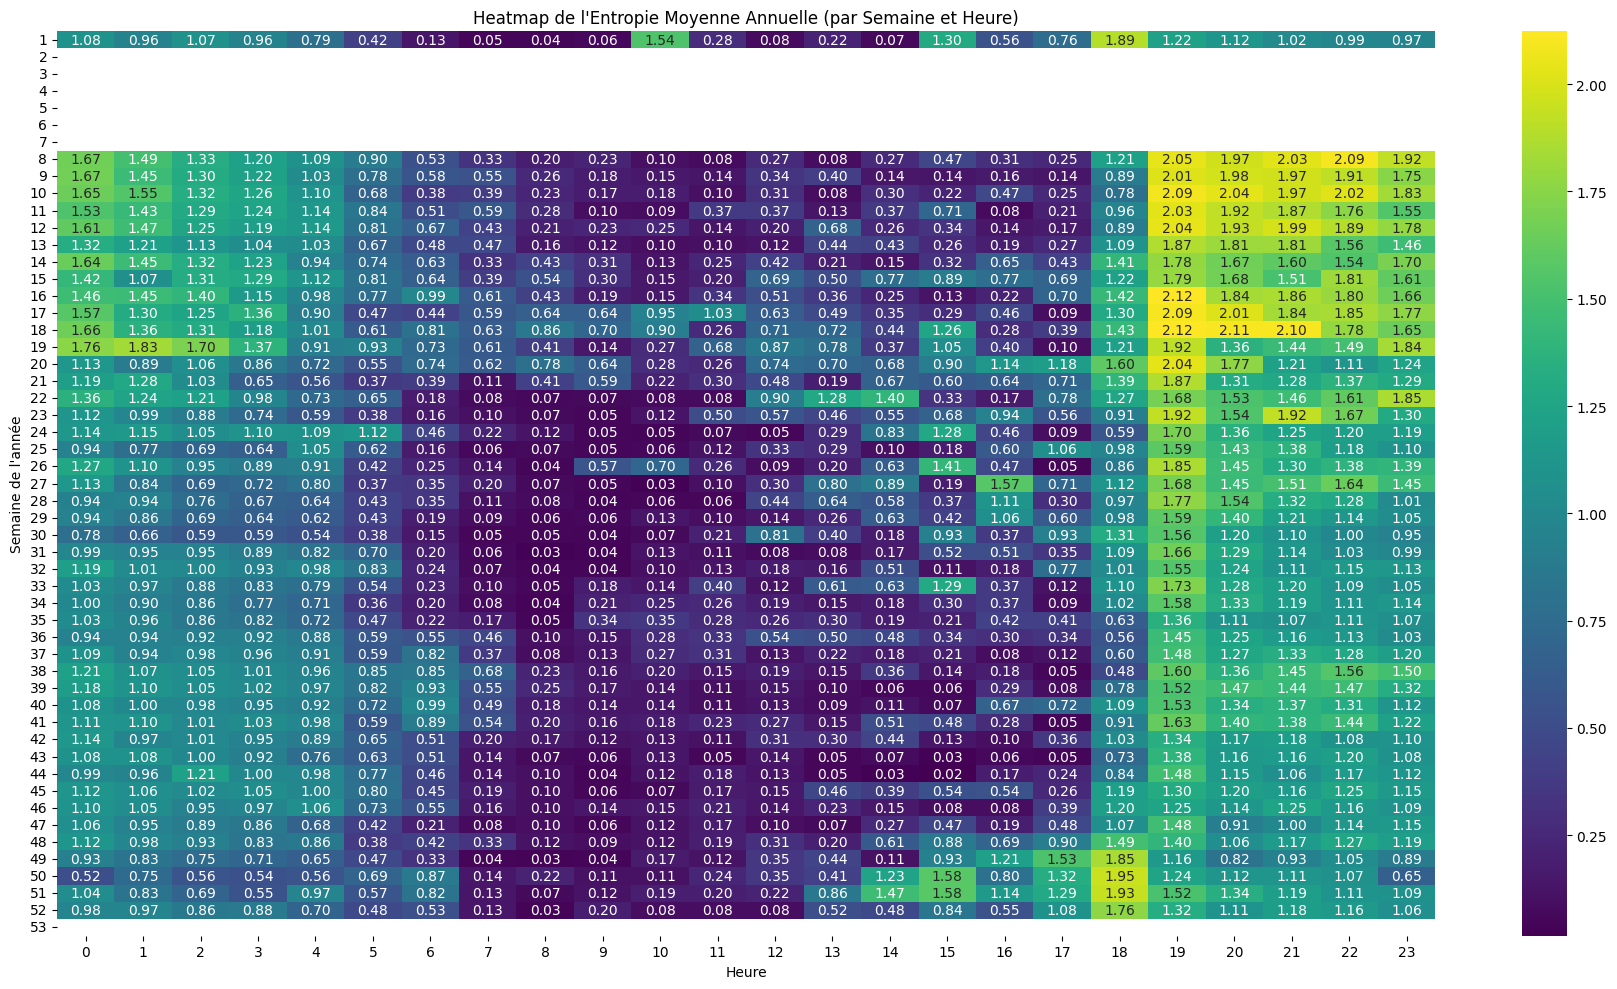

--- Génération de la Heatmap Annuelle Terminée ---


In [11]:
# Heatmap de l'Entropie Moyenne sur l'Année (par Semaine et Heure)

print("--- Génération de la Heatmaps de l'Entropie Moyenne Annuelle (par Semaine et Heure) ---")

# Ensure df_combined is available and has the necessary columns
if 'df_combined' in locals() or 'df_combined' in globals():
    # Create columns for week of the year and hour
    df_combined['week_of_year'] = df_combined.index.isocalendar().week.astype(int)
    df_combined['hour'] = df_combined.index.hour

    # Group by week and hour and calculate the mean entropy
    # Use pivot_table to easily reshape for the heatmap
    entropy_yearly_heatmap_data = df_combined.pivot_table(
        values='entropie_moy',
        index='week_of_year',
        columns='hour',
        aggfunc='mean' # Calculate the mean entropy for each week-hour cell
    )

    # Fill potential missing week/hour combinations with NaN for consistent heatmap
    all_weeks = range(1, 54) # Weeks of the year (can be up to 53)
    all_hours = range(24)
    entropy_yearly_heatmap_data = entropy_yearly_heatmap_data.reindex(index=all_weeks, columns=all_hours)


    # Plot the heatmap
    if not entropy_yearly_heatmap_data.empty:
        plt.figure(figsize=(18, 10)) # Adjust figure size for better readability
        sns.heatmap(
            entropy_yearly_heatmap_data,
            cmap="viridis", # Colormap for continuous values
            vmin=np.nanmin(entropy_yearly_heatmap_data) if not np.all(np.isnan(entropy_yearly_heatmap_data)) else None,
            vmax=np.nanmax(entropy_yearly_heatmap_data) if not np.all(np.isnan(entropy_yearly_heatmap_data)) else None,
            xticklabels=range(24), # Hours
            yticklabels=all_weeks, # Weeks
            annot=True, # Set to True for values, but might be too crowded for a year # Changed to True
            fmt=".2f" # Format annotations if annot=True
        )
        plt.title("Heatmap de l'Entropie Moyenne Annuelle (par Semaine et Heure)")
        plt.xlabel("Heure")
        plt.ylabel("Semaine de l'année")
        plt.tight_layout()
        plt.show()
    else:
        print("Aucune donnée d'entropie moyenne disponible pour générer la heatmap annuelle.")

else:
    print("Le DataFrame 'df_combined' n'est pas disponible. Veuillez exécuter les cellules précédentes.")

print("--- Génération de la Heatmap Annuelle Terminée ---")

/tmp/ipykernel_351807/490615513.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap("tab10")  # or "Set1", "Accent", etc.
/tmp/ipykernel_351807/490615513.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


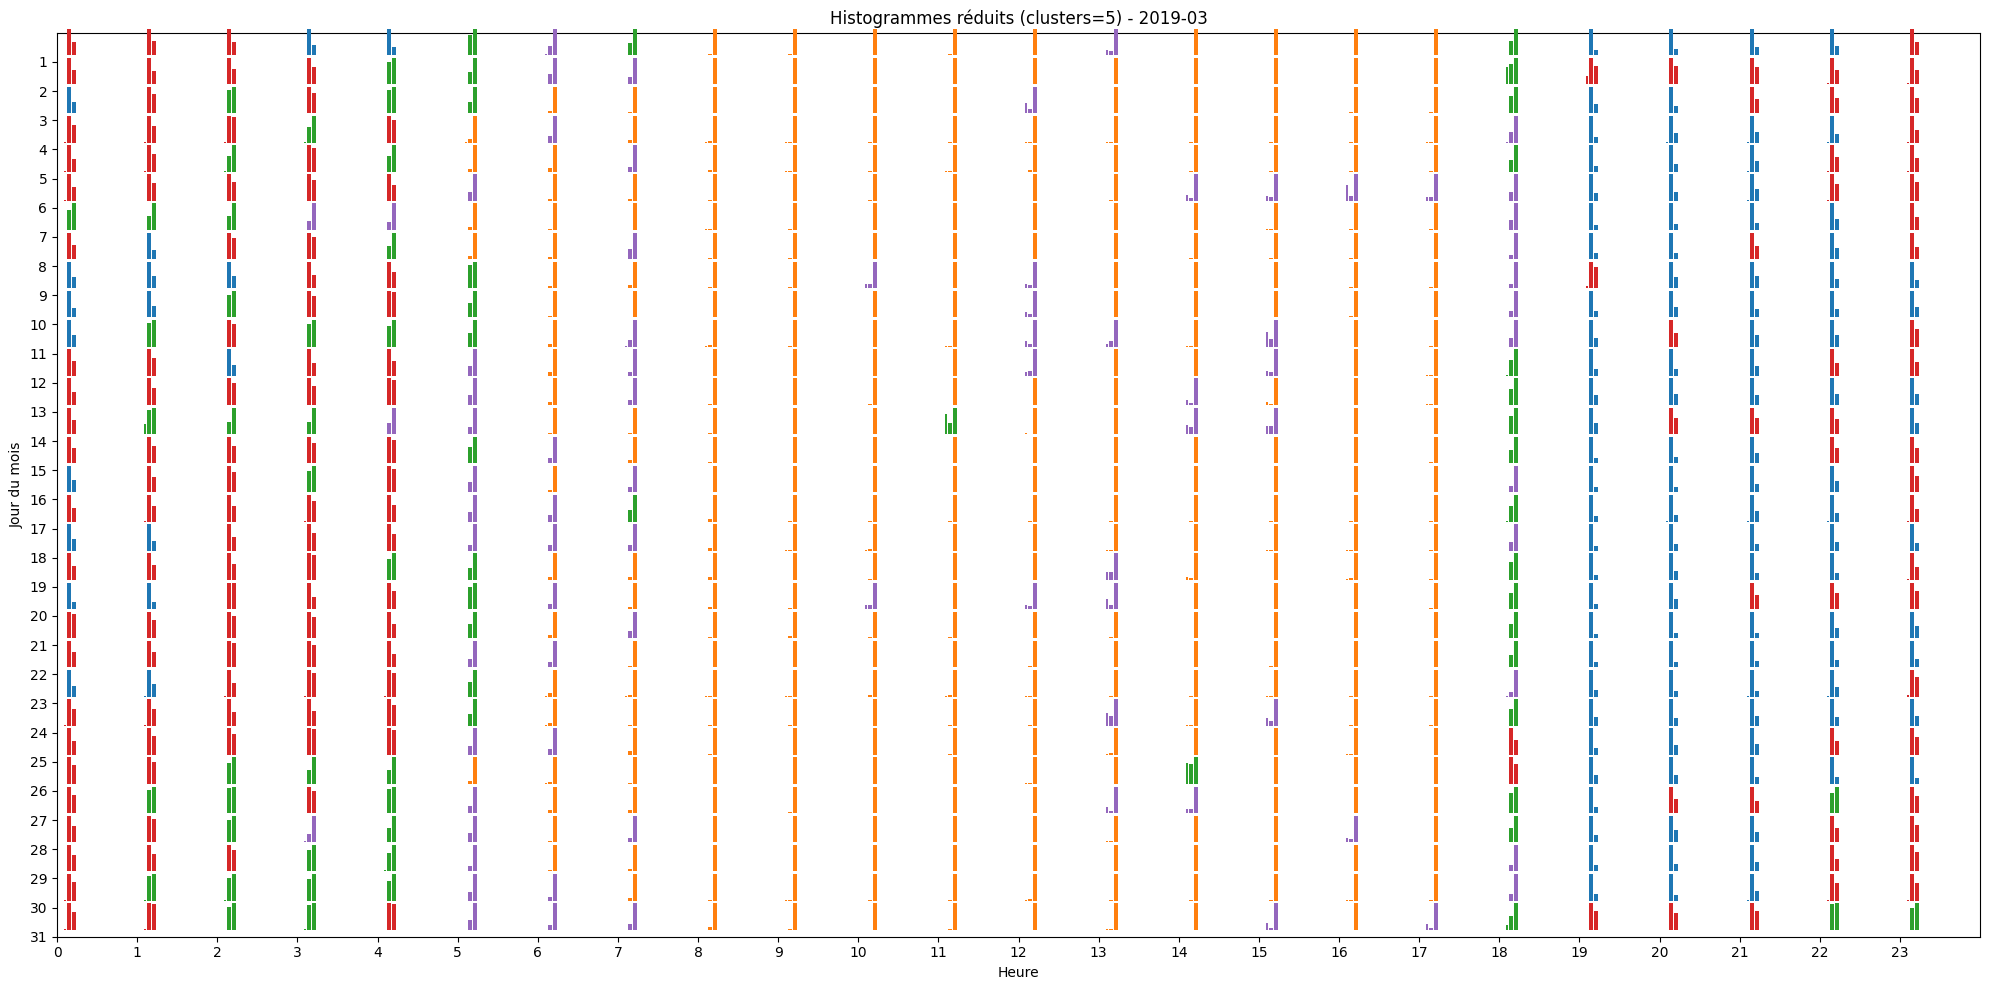

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap

def reduce_hist(hist, bins_reduits=32):
    """
    Réduit un histogramme 4096 bins → N bins (par défaut 32) par regroupement et sommation.
    Utilise la somme car les histogrammes sont déjà normalisés.
    """
    hist = np.array(hist)
    if hist.size != 4096:
        return np.zeros(bins_reduits)

    # Découpe et somme par bloc
    facteur = 4096 // bins_reduits
    hist_reduit = hist[:facteur * bins_reduits].reshape(bins_reduits, facteur).sum(axis=1)

    # Normalise à nouveau si nécessaire
    total = hist_reduit.sum()
    return hist_reduit / total if total > 0 else hist_reduit

def plot_clustered_histograms(fichiers_par_date, annee, mois, bins_reduits=16, n_clusters=5):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.set_xlim(0, 24)
    ax.set_ylim(0, 31)
    ax.invert_yaxis()
    ax.set_xticks(np.arange(24))
    ax.set_xticklabels(np.arange(24))
    ax.set_yticks(np.arange(31) + 1)
    ax.set_yticklabels(np.arange(1, 32))
    ax.set_xlabel("Heure")
    ax.set_ylabel("Jour du mois")
    ax.set_title(f"Histogrammes réduits (clusters={n_clusters}) - {annee}-{mois:02d}")

    # Step 1: collect all valid reduced histograms
    all_histograms = []
    histo_locations = []  # [(day, hour), ...]

    if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
        for jour in fichiers_par_date[annee][mois]:
            histograms_par_heure = {h: [] for h in range(24)}
            fichiers = fichiers_par_date[annee][mois][jour]
            for f in fichiers:
                if 'histogramme' in f and f['histogramme'] is not None and len(f['histogramme']) == 4096:
                    h = f['datetime_arrondi'].hour
                    reduced = reduce_hist(f['histogramme'], bins_reduits)
                    histograms_par_heure[h].append(reduced)

            for h in range(24):
                hists = histograms_par_heure[h]
                if hists:
                    avg_hist = np.mean(np.vstack(hists), axis=0)
                    all_histograms.append(avg_hist)
                    histo_locations.append((jour, h))

    if not all_histograms:
        print("No valid histograms for this month.")
        return

    # Step 2: Cluster histograms
    kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
    labels = kmeans.fit_predict(all_histograms)

    # Step 3: Create color map
    cmap = get_cmap("tab10")  # or "Set1", "Accent", etc.

    # Step 4: Plot each histogram in its grid cell with cluster color
    for (jour, h), hist, label in zip(histo_locations, all_histograms, labels):
        color = cmap(label)

        inset = inset_axes(ax,
                           width="100%", height="100%",
                           bbox_to_anchor=(h, jour - 1, 1, 1),
                           bbox_transform=ax.transData,
                           loc='lower left')
        inset.bar(range(bins_reduits), hist, color=color)
        inset.set_xticks([])
        inset.set_yticks([])
        inset.set_xlim(0, bins_reduits)
        inset.set_ylim(0, np.max(hist) * 1.1 if np.max(hist) > 0 else 1)
        inset.axis('off')

    plt.tight_layout()
    plt.show()
plot_clustered_histograms(fichiers_par_date, annee_viz, mois_viz)

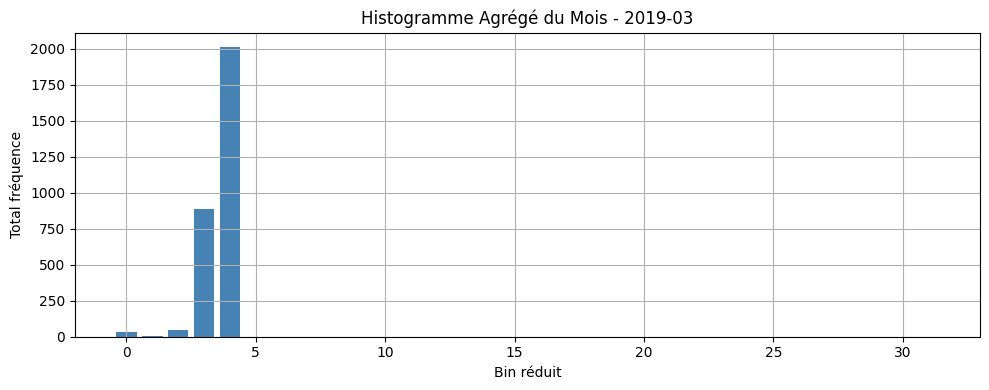

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def histogramme_mensuel(fichiers_par_date, annee, mois, bins_reduits=32):
    """
    Agrège tous les histogrammes du mois et les réduit pour afficher un seul histogramme global.
    """
    all_hists = []

    if annee in fichiers_par_date and mois in fichiers_par_date[annee]:
        for jour in fichiers_par_date[annee][mois]:
            for f in fichiers_par_date[annee][mois][jour]:
                if 'histogramme' in f and f['histogramme'] is not None and len(f['histogramme']) == 4096:
                    reduced = reduce_hist(f['histogramme'], bins_reduits)
                    all_hists.append(reduced)

    if not all_hists:
        print("Aucun histogramme trouvé pour ce mois.")
        return

    total_hist = np.sum(np.vstack(all_hists), axis=0)

    # Affichage
    plt.figure(figsize=(10, 4))
    plt.bar(range(bins_reduits), total_hist, color='steelblue')
    plt.title(f"Histogramme Agrégé du Mois - {annee}-{mois:02d}")
    plt.xlabel("Bin réduit")
    plt.ylabel("Total fréquence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

histogramme_mensuel(fichiers_par_date, annee_viz, mois_viz)